In [1]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import editdistance
from transer import Dataset
from transer import Trainer
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset = Dataset('train.csv')
words_vocab = dataset.words_vocab
trans_vocab = dataset.trans_vocab

In [3]:
class GeneralAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GeneralAttention, self).__init__()
        
        self.linear1 = nn.Linear(hidden_size, hidden_size, bias = False)
        
    def forward(self, query, context, mask = None):
        '''
        Inputs:
            query:   (batch x dec_seq_len x hidden) - outputs of decoder
            context: (batch x enc_sec_len x hidden) - outputs of encoder
            mask:    (batch x enc_seq_len)
        Outputs:
            weights: (batch x dec_seq_len x enc_sec_len)
            outputs: (batch x dec_sec_len x hidden)
        '''
        context = self.linear1(context)
        logits  = torch.matmul(query, context.transpose(1,2)) #batch x dec_sec_len x enc_sec_len
        if mask is not None:
            mask    = mask.unsqueeze(1)                       #batch x 1 x enc_sec_len
            logits.masked_fill_(1-mask , -float('inf'))       #batch x dec_sec_len x enc_sec_len
        #print(logits.size()) 
        weights = F.softmax(logits, dim = 2)                  #batch x dec_sec_len x enc_sec_len
        outputs = torch.matmul(weights, context)              #batch x dec_sec_len x hidden  
        
        return weights, outputs

In [4]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.linear1 = nn.Linear(2*hidden_size, hidden_size, bias = False)
        self.linear2 = nn.Linear(hidden_size,1, bias = False)
        
    def forward(self, query, context, mask = None):
        '''
        Inputs:
            query:   (batch x dec_seq_len x hidden) - outputs of decoder
            context: (batch x enc_sec_len x hidden) - outputs of encoder
            mask:    (batch x enc_seq_len)
        Outputs:
            weights: (batch x dec_seq_len x enc_sec_len)
            outputs: (batch x dec_sec_len x hidden)
        '''
        dec_sec_len  = query.size(1)
        enc_sec_len  = context.size(1)
        context1     = context
        query        = query.unsqueeze(2)                  #batch x dec_sec_len x 1 x hidden
        context      = context.unsqueeze(1)                #batch x 1 x enc_sec_len x hidden
        x            = query.repeat(1,1,enc_sec_len,1)     #batch x dec_sec_len x enc_sec_len x hidden
        y            = context.repeat(1,dec_sec_len,1,1)   #batch x dec_sec_len x enc_sec_len x hidden
        concat       = torch.cat([x,y], dim = -1)          #batch x dec_sec_len x enc_sec_len x 2*hidden
        a            = self.linear1(concat)                #batch x dec_sec_len x enc_sec_len x hidden   
        a            = F.tanh(a)
        weights      = self.linear2(a)                     #batch x dec_sec_len x enc_sec_len x 1
        weights      = weights.squeeze(-1)                 #batch x dec_sec_len x enc_sec_len
        if mask is not None:
            mask     = mask.unsqueeze(1)                   #batch x 1 x enc_sec_len
            weights.masked_fill_(1-mask, -float('inf'))    #batch x dec_sec_len x enc_sec_len
        weights      = F.softmax(weights, dim = 2)         #batch x dec_sec_len x enc_sec_len
        outputs      = torch.matmul(weights, context1)     #batch x dec_sec_len x hidden        
        return weights, outputs

In [5]:
attention = BahdanauAttention(32)
query   = torch.rand(64,15,32)
context = torch.rand(64,28,32)
mask    = torch.zeros(64,28).type(torch.ByteTensor)

weights, outputs = attention(query, context, mask)
print(weights.size(), outputs.size())

torch.Size([64, 15, 28]) torch.Size([64, 15, 32])


/home/raushan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [6]:
class Dotattention(nn.Module):
    def __init__(self):
        super(Dotattention, self).__init__()
        
    def forward(self, query, context, mask = None):
        '''
        Inputs:
            query:   (batch x dec_seq_len x hidden) - outputs of decoder
            context: (batch x enc_sec_len x hidden) - outputs of encoder
            mask:    (batch x enc_seq_len)
        Outputs:
            weights: (batch x dec_seq_len x enc_sec_len)
            outputs: (batch x dec_sec_len x hidden)
        '''
        
        logits  = torch.matmul(query, context.transpose(1,2)) #batch x dec_sec_len x enc_sec_len
     
        if mask is not None:
            mask    = mask.unsqueeze(1)                       #batch x 1 x enc_sec_len
            logits.masked_fill_(1-mask , -float('inf'))       #batch x dec_sec_len x enc_sec_len
        #print(logits.size()) 
        weights = F.softmax(logits, dim = 2)                  #batch x dec_sec_len x enc_sec_len
        outputs = torch.matmul(weights, context)              #batch x dec_sec_len x hidden  
        
        return weights, outputs

In [7]:
attention = BahdanauAttention(32)

In [8]:
query   = torch.rand(64,15,32)
context = torch.rand(64,28,32)
mask    = torch.ones(64,28).type(torch.ByteTensor)

weights, outputs = attention(query, context, mask)
print(weights.size(), outputs.size())

torch.Size([64, 15, 28]) torch.Size([64, 15, 32])


/home/raushan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru       = nn.GRU(emb_size, hidden_size, batch_first = True)
    
    def forward(self, source, source_lens=None):
        embedded = self.embedding(source)
        
        if source_lens is not None:
            embedded = pack(embedded, source_lens, batch_first = True)
  
        outs, hidden = self.gru(embedded)
    
        if source_lens is not None:
            outs,_ = unpack(outs, batch_first = True)
        
        return outs, hidden

In [13]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx, attention_type = None):
        super(Decoder, self).__init__()
        
        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size
        self.attention_type = attention_type
        
        self.embedding  = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru        = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.linear_out = nn.Linear(hidden_size, vocab_size)
        self.linear     = nn.Linear(2*hidden_size, hidden_size, bias = False)
        
        #self.attention  = GeneralAttention(hidden_size)
        self.attention   = BahdanauAttention(hidden_size)
        
    def forward(self, batch_trans_in, encoder_outputs, mask = None):
        embedded         = self.embedding(batch_trans_in)
        outs, hidden     = self.gru(embedded)
        #print("decoder outputs size", outs.size())
        #print("encoder outputs size", encoder_outputs.size())
        weights, outputs = self.attention(outs, encoder_outputs)
        concatenated     = torch.cat([outs, outputs], dim = -1) 
        
        x                = self.linear(concatenated)
        x                = F.tanh(x)
        pred             = self.linear_out(x)
        #view?
        return pred, hidden

In [11]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, trans_vocab_len):
        super(Model, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.trans_vocab_len = trans_vocab_len
        #logits = []
        
    def forward(self, batch_words, words_lens, batch_trans_in, mask_attention = None):
        outputs, hidden = self.encoder(batch_words, words_lens)
        if mask_attention is None:
            logits, hidden   = self.decoder(batch_trans_in, outputs)
        else:
            logits, hidden    = self.decoder(batch_trans_in, outputs, mask_attention)
            
        #logits = torch.stack(logits, 1)
        #print('logits size before view', logits.size())
        logits = logits.view(-1, self.trans_vocab_len) 
        return logits
    
    def generate(self, bos_idx, eos_idx, batch_words):
        inp = [bos_idx]
        _, hidden = self.encoder(batch_words)

        for _ in range(100):
            inp_tensor = torch.LongTensor([[inp[-1]]]).to(batch_words.device)
            pred, hidden   = self.decoder(inp_tensor, hidden)
            next_token = pred[-1].topk(1)[1].item()
            inp.append(next_token)
            if next_token == eos_idx:
                break
        return inp   

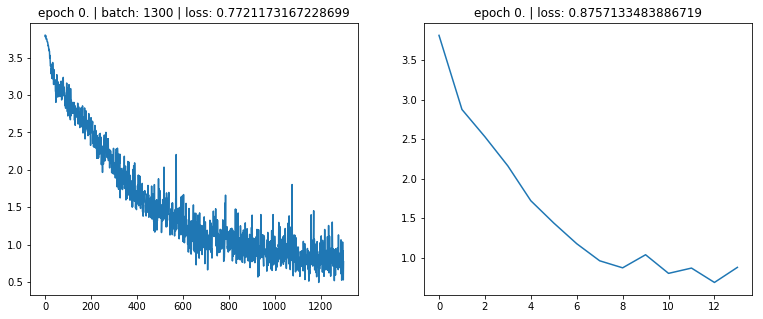

decoder outputs size torch.Size([10, 10, 64])
encoder outputs size torch.Size([10, 12, 64])
decoder outputs size torch.Size([10, 11, 64])
encoder outputs size torch.Size([10, 12, 64])
decoder outputs size torch.Size([10, 14, 64])
encoder outputs size torch.Size([10, 15, 64])
decoder outputs size torch.Size([10, 10, 64])
encoder outputs size torch.Size([10, 10, 64])
decoder outputs size torch.Size([10, 10, 64])
encoder outputs size torch.Size([10, 9, 64])
decoder outputs size torch.Size([10, 10, 64])
encoder outputs size torch.Size([10, 11, 64])
decoder outputs size torch.Size([10, 17, 64])
encoder outputs size torch.Size([10, 18, 64])
decoder outputs size torch.Size([10, 9, 64])
encoder outputs size torch.Size([10, 10, 64])
decoder outputs size torch.Size([10, 15, 64])
encoder outputs size torch.Size([10, 17, 64])
decoder outputs size torch.Size([10, 10, 64])
encoder outputs size torch.Size([10, 10, 64])
decoder outputs size torch.Size([10, 9, 64])
encoder outputs size torch.Size([10, 

KeyboardInterrupt: 

In [12]:
decoder = Decoder(len(trans_vocab), 32, 64, pad_idx = words_vocab.pad_idx)
encoder = Encoder(len(words_vocab), 32, 64, pad_idx = trans_vocab.pad_idx)


model   = Model(encoder, decoder, len(trans_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

batch_size = 10
num_epochs = 3
totrain = Trainer(dataset, model, optimizer, criterion)
totrain.train(num_epochs, batch_size)

In [ ]:
def _print(val):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = dataset.get_batch(1, sort=True, val=True)
    batch_words     = batch_words.to(device)
    words_lens      = words_lens.to(device)
    batch_trans_out = batch_trans_out.to(device)
    mask_attention  = batch_words != dataset.words_vocab.pad_idx

    inp = model.generate(dataset.words_vocab.sos_idx, dataset.words_vocab.eos_idx, batch_words, words_lens, mask_attention)

    tokens = [dataset.trans_vocab.idx2token(idx) for idx in inp if idx not in [dataset.trans_vocab.sos_idx,
                                                                       dataset.trans_vocab.eos_idx,
                                                                       dataset.trans_vocab.pad_idx]]
    print('Src: ', ''.join([dataset.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    print('Real:', ''.join([dataset.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [dataset.trans_vocab.sos_idx,
                                                                            dataset.trans_vocab.eos_idx,
                                                                            dataset.trans_vocab.pad_idx]]))

In [ ]:
for _ in range(10):
    _print(True)
    print()